# Here I'm checking for using smote with and without word2vec, glove twitter with MLP classifiers

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader

from sklearn.neural_network import MLPClassifier

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### All the below steps aree from previous part 1

In [4]:
df_train=pd.read_csv('labeled_data.csv')

In [5]:
# No empty data..plus Id is there, which I don't need. So, I'm dropping it
df_train.drop(labels=['Unnamed: 0'],axis=1,inplace=True)

In [6]:
df_train.loc[(df_train['class']== 1)|(df_train['class']==2),'class']=3


In [7]:
df_train.loc[(df_train['class']== 0),'class']=1

In [8]:
df_train.loc[(df_train['class']== 3),'class']=0

In [9]:
hatespeech=df_train[df_train['class']==1]['class'].count()
not_hatespeech=df_train[df_train['class']==0]['class'].count()

Text(0.5, 1.0, 'Class Distribution')

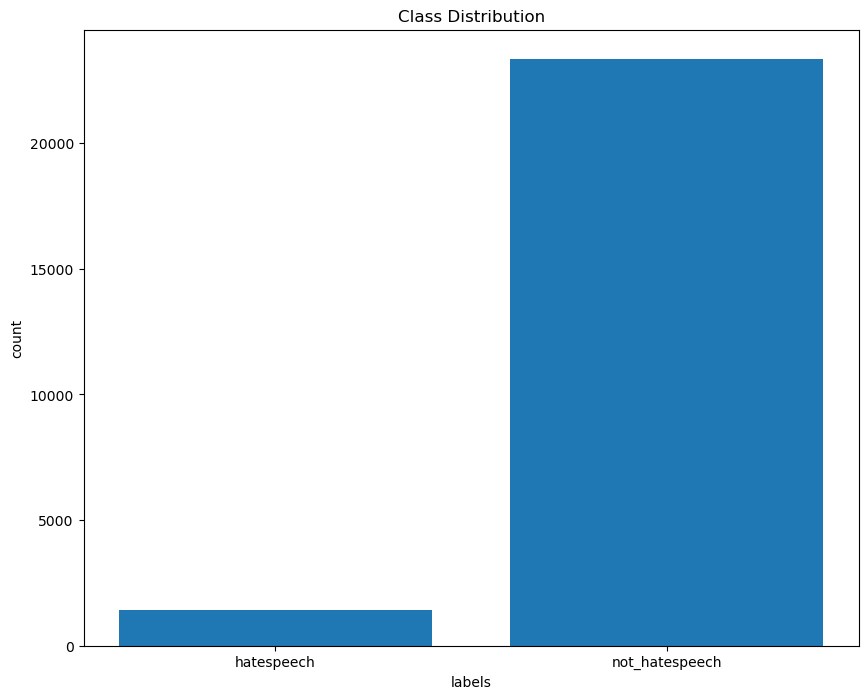

In [10]:
plt.figure(figsize=(10,8))
plt.bar(x=['hatespeech','not_hatespeech'],height=[hatespeech,not_hatespeech])
plt.xlabel('labels')
plt.ylabel('count')
plt.title('Class Distribution')

In [11]:
X=df_train['tweet']
y=df_train['class']

In [12]:
y.value_counts()

class
0    23353
1     1430
Name: count, dtype: int64

### Using glove embeddings for word2vec

In [15]:
word2Vec = gensim.downloader.load('glove-twitter-200')

In [16]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(row):
    row = row.lower()
    row = re.sub(r'[^\w\s]', '', row)
    words = row.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words) if words else 'empty'

        

In [17]:
# Function to get the average vector for a set of reviews
def get_average_vector(texts,label):    
    training_vectors=[]
    count_label=[]
    for row in texts:
        row = preprocess(row)  # Preprocessing remains consistent
        words = row.split(" ")
        vector_list = []
        for word in words:
            if word in word2Vec:  # Ensure word is in the GloVe model
                vector_list.append(word2Vec[word])
        if vector_list:
            training_vectors.append(np.mean(vector_list, axis=0))  # Simple average across vectors
        else:
            training_vectors.append(np.zeros(word2Vec.vector_size))# Return zeros if no vectors found
        count_label.append(label)
    return training_vectors,count_label

In [40]:
def train_MLP_model_average(train_df):
    #word2Vec = gensim.downloader.load('glove-twitter-25')
    positive_labels=train_df[train_df['class']==1]['tweet']
    negative_labels=train_df[train_df['class']==0]['tweet']
    positive_vector,positive_label=get_average_vector(positive_labels,1)
    negative_vector,negative_label=get_average_vector(negative_labels,0)
    X_train=positive_vector+negative_vector
    y_train=positive_label+negative_label
    mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=500, random_state=42)
    # Convert lists to numpy arrays for model training
    print(len(X_train),len(y_train))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    mlp.fit(X_train,y_train)
    return mlp

In [41]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(df_train, test_size=0.2, random_state=42, stratify=y)

In [42]:
mlp=train_MLP_model_average(train)

19826 19826


In [43]:
def test_MLP_model(test, MLP_model, input_type='average'):
    '''df_test = pd.read_csv(path_to_test_file, sep='\t', header=None)
    df_test = df_test.rename(columns={0: 'text', 1: 'label'})'''

    # Helper function to choose between average and max pooling
    def get_text_vector(text):
        text = preprocess(text)
        words = text.split(" ")
        vector_list = []
        for word in words:
            if word in word2Vec:
                vector_list.append(word2Vec[word])
        if vector_list:
            if input_type == 'average':
                return np.mean(vector_list, axis=0)  # Average vector
        else:
            return np.zeros(word2Vec.vector_size)  # Zero vector if no valid words

    # Create vectors for the test set
    X_test = np.array([get_text_vector(row) for row in test['tweet']])
    y_test = test['class'].values
    
    # Get predictions and probabilities
    y_pred = MLP_model.predict(X_test)
    y_prob = MLP_model.predict_proba(X_test)[:, 1]  # Probability of being positive

    # Add new columns to the test dataframe
    test['probability_positive'] = y_prob
    test['predicted_class'] = y_pred

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    conf_matrix = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')

    # Print metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix:\n{conf_matrix}")


#### Result without Smote and twitter 200

In [44]:
test_MLP_model(test,mlp) #twitter 200 without smote

Accuracy: 0.9372604397821263
Precision: 0.4161073825503356
Recall: 0.21678321678321677
F1 Score: 0.2850574712643678
Confusion Matrix:
[[4584   87]
 [ 224   62]]


In [48]:
test[test['class']==1].count()

count                   286
hate_speech             286
offensive_language      286
neither                 286
class                   286
tweet                   286
probability_positive    286
predicted_class         286
dtype: int64

In [49]:
!pip install scikit-learn
!pip install imbalanced-learn

In [52]:
!pip install scikit-learn==0.24.2
!pip install imbalanced-learn==0.8.0


     ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/7.5 MB 325.1 kB/s eta 0:00:24
     ---------------------------------------- 0.1/7.5 MB 491.5 kB/s eta 0:00:16
     - -------------------------------------- 0.3/7.5 MB 1.5 MB/s eta 0:00:05
     --- ------------------------------------ 0.7/7.5 MB 3.4 MB/s eta 0:00:03
     ------- -------------------------------- 1.4/7.5 MB 5.1 MB/s eta 0:00:02
     ----------- ---------------------------- 2.1/7.5 MB 6.6 MB/s eta 0:00:01
     -------------- ------------------------- 2.7/7.5 MB 7.4 MB/s eta 0:00:01
     ----------------- ---------------------- 3.3/7.5 MB 8.1 MB/s eta 0:00:01
     --------------------- ------------------ 4.0/7.5 MB 8.9 MB/s eta 0:00:01
     ------------------------- -------------- 4.8/7.5 MB 9.5 MB/s eta 0:00:01
     ----------------------------- ---------- 5.5/7.5 MB 10.0 MB/s eta 0:0

  error: subprocess-exited-with-error
  
  Preparing metadata (pyproject.toml) did not run successfully.
  exit code: 1
  
  [59 lines of output]
  <string>:17: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  Partial import of sklearn during the build process.
  <string>:116: DeprecationWarning:
  
    `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
    of the deprecation of `distutils` itself. It will be removed for
    Python >= 3.12. For older Python versions it will remain present.
    It is recommended to use `setuptools < 60.0` for those Python versions.
    For more details, see:
      https://numpy.org/devdocs/reference/distutils_status_migration.html
  
  
  INFO: No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
  Traceback (most recent call last):
    File "C:\Users\acer\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_proces

  Obtaining dependency information for imbalanced-learn==0.8.0 from https://files.pythonhosted.org/packages/80/98/dc784205a7e3034e84d41ac4781660c67ad6327f2f5a80c568df31673d1c/imbalanced_learn-0.8.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/206.5 kB ? eta -:--:--
   --- ----------------------------------- 20.5/206.5 kB 682.7 kB/s eta 0:00:01
   ------------- ------------------------- 71.7/206.5 kB 787.7 kB/s eta 0:00:01
   ---------------------------------------- 206.5/206.5 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.9.0
    Uninstalling imbalanced-learn-0.9.0:
      Successfully uninstalled imbalanced-learn-0.9.0


In [61]:
from imblearn.over_sampling import SMOTE

def train_MLP_model_average(train_df):
    positive_labels = train_df[train_df['class'] == 1]['tweet']
    negative_labels = train_df[train_df['class'] == 0]['tweet']
    positive_vector, positive_label = get_average_vector(positive_labels, 1)
    negative_vector, negative_label = get_average_vector(negative_labels, 0)
    X_train = positive_vector + negative_vector
    y_train = positive_label + negative_label

    # Apply SMOTE to handle class imbalance
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=500, random_state=42)
    mlp.fit(X_res, y_res)  # Use resampled data for training

    return mlp


In [62]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(df_train, test_size=0.2, random_state=42, stratify=y)

In [63]:
mlp=train_MLP_model_average(train)

#### Result with Smote and twitter 200

In [64]:
test_MLP_model(test,mlp)#glove-twitter-200 with smote

Accuracy: 0.9239459350413557
Precision: 0.3333333333333333
Recall: 0.3181818181818182
F1 Score: 0.32558139534883723
Confusion Matrix:
[[4489  182]
 [ 195   91]]


In [65]:
word2Vec = gensim.downloader.load('word2vec-google-news-300')

In [66]:
mlp=train_MLP_model_average(train)

#### Result with smote and word2evec-google-300

In [67]:
test_MLP_model(test,mlp)#word2evec-google-300 with smote

Accuracy: 0.9009481541254791
Precision: 0.24181360201511334
Recall: 0.3356643356643357
F1 Score: 0.28111273792093705
Confusion Matrix:
[[4370  301]
 [ 190   96]]


In [69]:
def train_MLP_model_average(train_df):
    #word2Vec = gensim.downloader.load('glove-twitter-25')
    positive_labels=train_df[train_df['class']==1]['tweet']
    negative_labels=train_df[train_df['class']==0]['tweet']
    positive_vector,positive_label=get_average_vector(positive_labels,1)
    negative_vector,negative_label=get_average_vector(negative_labels,0)
    X_train=positive_vector+negative_vector
    y_train=positive_label+negative_label
    mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=500, random_state=42)
    # Convert lists to numpy arrays for model training
    print(len(X_train),len(y_train))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    mlp.fit(X_train,y_train)
    return mlp

#### Result without smote and word2evec-google-300

In [71]:
mlp=train_MLP_model_average(train)
test_MLP_model(test,mlp) #tword2evec-google-300 without smote

19826 19826
Accuracy: 0.9334274762961469
Precision: 0.3674698795180723
Recall: 0.21328671328671328
F1 Score: 0.26991150442477874
Confusion Matrix:
[[4566  105]
 [ 225   61]]


# Now checking for LR with word2vec embeddings